In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats
from datetime import date
import matplotlib.dates as mdates
from datetime import datetime, timedelta

import time
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [4]:
dfraw = pd.read_excel('https://drive.google.com/uc?export=download&id=1xHtu7PSm4w6EfJyt2cRiftgcEWnxr_8g')
dfraw.info()
pd.set_option('display.max_columns', None)
dfraw.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai                 282 non-n

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
217,sincereBass4,101615,Bercerai,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Biasa,Jakarta Pusat,Website,2,2.0,0.0,3.0,5.0,+6285679942xxx,sincereBass4134@yahoo.com,Sarjana,1,NaN,NaN,1974-05-09,2014-05-12,2020-1-17,-
127,scornfulDove3,101662,Lainnya,Wanita,FullTime,Data Engineer,Freshgraduate_program,Sangat_kurang,Jakarta Utara,Google_Search,4,3.0,0.0,0.0,3.0,+6285710367xxx,scornfulDove3185@gmail.com,Sarjana,1,NaN,jam_kerja,1953-05-24,2011-5-16,2018-4-18,2015-6-18
59,lazyToucan3,106660,Bercerai,Wanita,FullTime,Software Engineer (Front End),Freshgraduate_program,Kurang,Jakarta Utara,Diversity_Job_Fair,3,5.0,0.0,0.0,11.0,+6287705186xxx,lazyToucan3860@gmail.com,Magister,1,NaN,masih_bekerja,1975-04-03,2009-4-27,2013-2-15,-
82,artisticTacos7,100515,Belum_menikah,Wanita,Outsource,Software Engineer (Back End),Freshgraduate_program,Biasa,Jakarta Barat,Indeed,3,5.0,0.0,0.0,3.0,+6283134314xxx,artisticTacos7452@proton.com,Doktor,1,NaN,masih_bekerja,1988-05-31,2011-10-03,2020-1-30,-
78,somberCod8,110312,Bercerai,Pria,FullTime,Data Analyst,Mid_level,Sangat_bagus,Jakarta Barat,Employee_Referral,4,4.0,0.0,0.0,19.0,+6289954216xxx,somberCod8452@icloud.com,Sarjana,1,NaN,masih_bekerja,1983-02-18,2013-9-30,2020-2-25,-


In [5]:
# Check duplicated rows
dfraw.duplicated().sum()

0

In [6]:
# Checking null values
null_cols = dfraw.columns[dfraw.isnull().any()]
null_val = dfraw[null_cols].isnull().sum().to_frame().reset_index()
null_val.columns = ['Column', 'Count']
null_val['Percent%'] = round(null_val['Count']/len(dfraw) * 100, 3)
null_val

,Column,Count,Percent%
0,SkorKepuasanPegawai,5,1.742
1,JumlahKeikutsertaanProjek,3,1.045
2,JumlahKeterlambatanSebulanTerakhir,1,0.348
3,JumlahKetidakhadiran,6,2.091
4,IkutProgramLOP,258,89.895
5,AlasanResign,66,22.997


In [7]:
dfraw.describe().T

,count,mean,std,min,25%,50%,75%,max
EnterpriseID,287.0,105923.324042,4044.977599,100282.0,101269.0,106069.0,110514.5,111703.0
SkorSurveyEngagement,287.0,3.101045,0.836388,1.0,3.0,3.0,4.0,5.0
SkorKepuasanPegawai,282.0,3.904255,0.913355,1.0,3.0,4.0,5.0,5.0
JumlahKeikutsertaanProjek,284.0,1.179577,2.294441,0.0,0.0,0.0,0.0,8.0
JumlahKeterlambatanSebulanTerakhir,286.0,0.412587,1.275016,0.0,0.0,0.0,0.0,6.0
JumlahKetidakhadiran,281.0,10.448399,6.902252,1.0,5.0,10.0,15.0,55.0
IkutProgramLOP,29.0,0.517241,0.508548,0.0,0.0,1.0,1.0,1.0


In [8]:
dfraw.describe(include="object").T

,count,unique,top,freq
Username,287,285,boredEggs0,2
StatusPernikahan,287,5,Belum_menikah,132
JenisKelamin,287,2,Wanita,167
StatusKepegawaian,287,3,FullTime,217
Pekerjaan,287,14,Software Engineer (Back End),109
JenjangKarir,287,3,Freshgraduate_program,169
PerformancePegawai,287,5,Biasa,85
AsalDaerah,287,5,Jakarta Pusat,72
HiringPlatform,287,9,Indeed,85
NomorHP,287,287,+6282232522xxx,1


# EDA

## Unique Value

In [9]:
dfraw['StatusPernikahan'].unique()

array(['Belum_menikah', 'Menikah', 'Bercerai', 'Lainnya', '-'],
      dtype=object)

In [10]:
# Rows with nan value in 'Status Pernikahan'
dfraw[dfraw['StatusPernikahan'] == '-']

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
106,troubledThrushe9,101192,-,Wanita,FullTime,Data Analyst,Freshgraduate_program,Bagus,Jakarta Barat,CareerBuilder,4,3.0,0.0,0.0,20.0,+6281801928xxx,troubledThrushe9146@proton.com,Sarjana,1,NaN,toxic_culture,1987-01-07,2013-01-07,2020-1-30,2014-8-19
255,amazedMoth0,106363,-,Wanita,Internship,Software Engineer (Front End),Senior_level,Biasa,Jakarta Pusat,Indeed,3,5.0,0.0,0.0,12.0,+6285931209xxx,amazedMoth0683@outlook.com,Magister,1,0.0,jam_kerja,1986-08-17,2011-5-16,2014-01-10,2018-04-01
283,yearningPorpoise4,106254,-,Wanita,FullTime,Product Design (UI & UX),Freshgraduate_program,Biasa,Jakarta Timur,LinkedIn,4,5.0,0.0,0.0,11.0,+6281222782xxx,yearningPorpoise4421@yahoo.com,Sarjana,1,NaN,jam_kerja,1974-12-01,2013-5-13,2020-1-28,2017-11-15


In [11]:
dfraw['StatusKepegawaian'].unique()

array(['Outsource', 'FullTime', 'Internship'], dtype=object)

In [12]:
dfraw['Pekerjaan'].unique()

array(['Software Engineer (Back End)', 'Data Analyst',
       'Software Engineer (Front End)', 'Product Manager',
       'Software Engineer (Android)', 'Scrum Master',
       'Product Design (UX Researcher)', 'Product Design (UI & UX)',
       'Digital Product Manager', 'Data Engineer',
       'Software Engineer (iOS)', 'DevOps Engineer', 'Software Architect',
       'Machine Learning Engineer'], dtype=object)

In [13]:
dfraw['PernahBekerja'].unique()

array([1, 'yes'], dtype=object)

In [14]:
dfraw['JenjangKarir'].unique()

array(['Freshgraduate_program', 'Senior_level', 'Mid_level'], dtype=object)

In [15]:
dfraw['PerformancePegawai'].unique()

array(['Sangat_bagus', 'Sangat_kurang', 'Bagus', 'Biasa', 'Kurang'],
      dtype=object)

In [16]:
dfraw['AsalDaerah'].unique()

array(['Jakarta Timur', 'Jakarta Utara', 'Jakarta Pusat',
       'Jakarta Selatan', 'Jakarta Barat'], dtype=object)

In [17]:
dfraw['HiringPlatform'].unique()

array(['Employee_Referral', 'Website', 'Indeed', 'LinkedIn',
       'CareerBuilder', 'Diversity_Job_Fair', 'Google_Search',
       'On-line_Web_application', 'Other'], dtype=object)

In [18]:
dfraw['TingkatPendidikan'].unique()

array(['Magister', 'Sarjana', 'Doktor'], dtype=object)

In [19]:
dfraw['AlasanResign'].unique()

array(['masih_bekerja', 'toxic_culture', 'jam_kerja', 'ganti_karir',
       'tidak_bahagia', 'internal_conflict', 'Product Design (UI & UX)',
       'kejelasan_karir', 'tidak_bisa_remote', 'apresiasi', nan,
       'leadership'], dtype=object)

Terlihat sepertinya semua nilai kolom kategorikal sudah sesuai, kecuali pada kolom `AlasanResign`. Selain memiliki null value di dalamnya, ada value yang tidak sesuai yaitu "Product Design" dimana seharusnya menjadi value pada kolom `Pekerjaan`. Karena abnormal value hanya 4 baris maka baris ini akan di drop nantinya.

In [20]:
# Rows with abnormal value in 'Alasan Resign'
dfraw[dfraw['AlasanResign'] == 'Product Design (UI & UX)']

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
27,pluckyApples4,110566,Menikah,Wanita,FullTime,Software Engineer (Front End),Senior_level,Biasa,Jakarta Selatan,LinkedIn,3,5.0,0.0,0.0,15.0,+6281988935xxx,pluckyApples4880@icloud.com,Sarjana,1,NaN,Product Design (UI & UX),1987-04-10,2016-07-06,2020-1-28,2016-08-07
124,dearKitten3,111266,Belum_menikah,Pria,FullTime,Product Design (UI & UX),Freshgraduate_program,Sangat_bagus,Jakarta Utara,Diversity_Job_Fair,3,3.0,0.0,0.0,19.0,+6289679074xxx,dearKitten3235@yahoo.com,Sarjana,1,NaN,Product Design (UI & UX),1989-05-02,2011-9-26,2014-03-02,2017-12-15
147,brainyLlama9,100884,Menikah,Wanita,FullTime,Software Engineer (Front End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,LinkedIn,3,5.0,0.0,0.0,20.0,+6285503547xxx,brainyLlama9557@gmail.com,Sarjana,1,NaN,Product Design (UI & UX),1969-02-09,2012-03-07,2014-02-01,2016-4-24
203,hushedBobolink8,106392,Menikah,Wanita,FullTime,Software Engineer (Back End),Mid_level,Sangat_bagus,Jakarta Selatan,Website,3,5.0,0.0,0.0,9.0,+6285522082xxx,hushedBobolink8263@outlook.com,Sarjana,1,NaN,Product Design (UI & UX),1988-08-29,2012-01-09,2020-02-01,2018-04-01


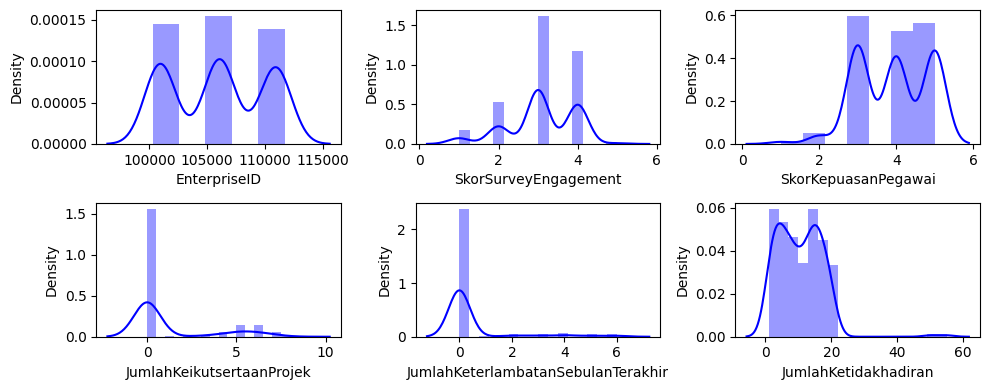

In [21]:
# Graph of Data Distribution
num = ['EnterpriseID', 'SkorSurveyEngagement', 'SkorKepuasanPegawai', 'JumlahKeikutsertaanProjek', 'JumlahKeterlambatanSebulanTerakhir', 'JumlahKetidakhadiran']

plt.figure(figsize=(10, 4))
for i in range(0, len(num)):
    plt.subplot(2, 3, i+1)
    sns.distplot(dfraw[num[i]], color='blue')
    plt.tight_layout()

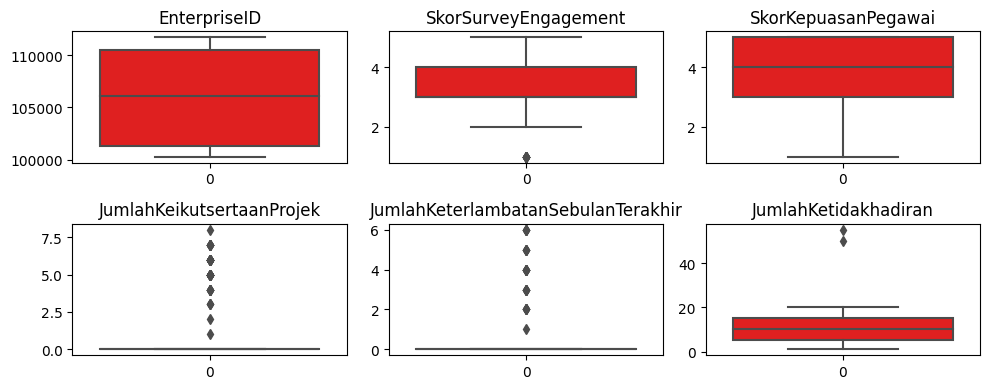

In [22]:
# Checking Outliers
plt.figure(figsize=(10, 4))
for i in range(0, len(num)):
    plt.subplot(2, 3,  i+1)
    sns.boxplot(dfraw[num[i]], color='red')
    plt.title(num[i])
    plt.tight_layout()

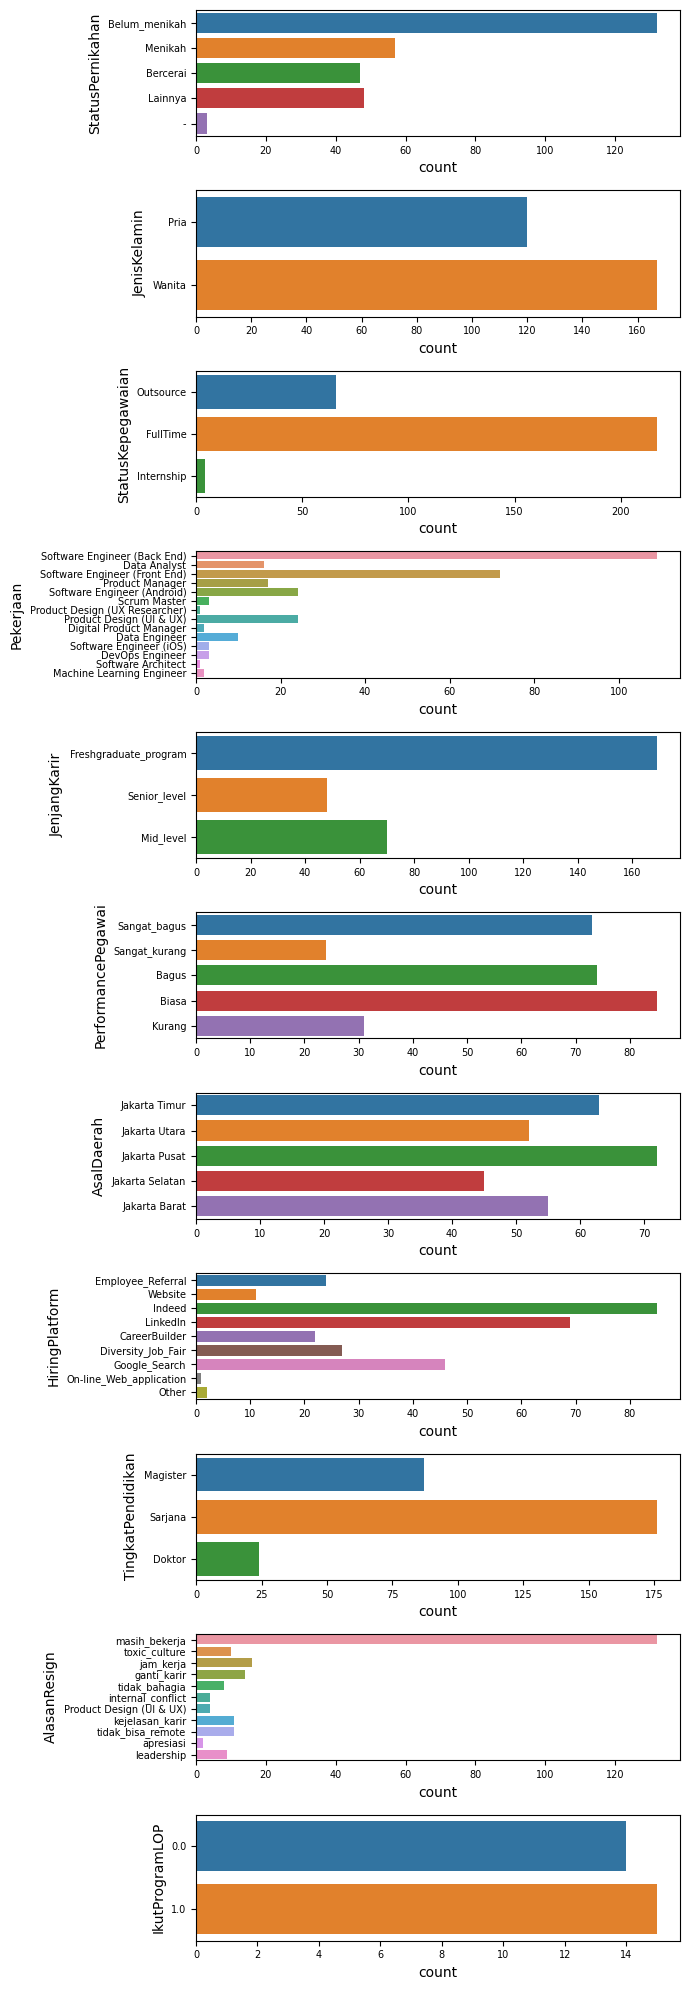

In [23]:
cat = ['StatusPernikahan','JenisKelamin','StatusKepegawaian','Pekerjaan','JenjangKarir','PerformancePegawai','AsalDaerah','HiringPlatform',
       'TingkatPendidikan','AlasanResign','IkutProgramLOP']

plt.figure(figsize=(7,20))
for i in range(len(cat)):
    plt.subplot( 11,1, i+1 )
    sns.countplot( data=dfraw, y=dfraw[cat[i]] )
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.tight_layout()

# Data Cleansing

### Dropping

In [24]:
dfclean = dfraw.copy()

In [25]:
# Drop columns
dfclean = dfclean.drop(columns=['PernahBekerja','Email','NomorHP','IkutProgramLOP'])
dfclean.shape

(287, 21)

### Handling Missing Values and Replace Invalid Values

- SkorKepuasanPegawai = 1.742 %    
- JumlahKeikutsertaanProjek = 1.045%  
- JumlahKeterlambatanSebulanTerakhir = 0.348%  
- JumlahKetidakhadiran = 2.091 %  
- IkutProgramLOP = 89.89 %  (Has been deleted)
- AlasanResign = 22.997 %
- StatusPernikahan = 3 rows (denoetd as nan)

In [26]:
# Handling missing values

# Replace Invalid Values
dfclean['StatusPernikahan'].replace('-', 'Lainnya', inplace=True)
dfclean['AlasanResign'].replace('Product Design (UI & UX)', 'Lainnya', inplace=True)

# Missing value in the reason for resign means they still working in company
dfclean['AlasanResign'] = dfclean['AlasanResign'].fillna('masih_bekerja')

# Fill numerical columns with median
dfclean['JumlahKeikutsertaanProjek'].fillna(dfclean['JumlahKeikutsertaanProjek'].median(), inplace=True)
dfclean['JumlahKeterlambatanSebulanTerakhir'].fillna(dfclean['JumlahKeterlambatanSebulanTerakhir'].median(), inplace=True)
dfclean['JumlahKetidakhadiran'].fillna(dfclean['JumlahKetidakhadiran'].median(), inplace=True)

# Fill other columns
dfclean['StatusPernikahan'] = dfclean['StatusPernikahan'].fillna('Lainnya')
dfclean['SkorKepuasanPegawai'].fillna(dfclean['SkorKepuasanPegawai'].mode()[0], inplace=True)

# Replace " - " value as not resign
dfclean['is_resign'] = np.where(dfclean['TanggalResign']=='-',0,1)

In [27]:
# Convert Data Type

dfclean['SkorKepuasanPegawai'] =  dfclean['SkorKepuasanPegawai'].astype('int64')
dfclean['JumlahKeikutsertaanProjek'] = dfclean['JumlahKeikutsertaanProjek'].astype('int64')
dfclean['JumlahKeterlambatanSebulanTerakhir'] = dfclean['JumlahKeterlambatanSebulanTerakhir'].astype('int64')
dfclean['JumlahKetidakhadiran'] = dfclean['JumlahKetidakhadiran'].astype('int64')
dfclean['TanggalLahir'] = pd.to_datetime(dfclean['TanggalLahir'])
dfclean['TanggalHiring'] = pd.to_datetime(dfclean['TanggalHiring'])
dfclean['TanggalPenilaianKaryawan'] = pd.to_datetime(dfclean['TanggalPenilaianKaryawan'])

All clear now!

# Data Visualization

## Annual Report on Employee Number

In [28]:
dfviz = dfclean.copy()

In [29]:
# Group by to see total hiring and resign each year

dfviz['TanggalResign'] = pd.to_datetime(dfviz['TanggalResign'], errors='coerce')

hiring_year = dfviz.groupby(dfviz['TanggalHiring'].dt.year)[['Username']].count().reset_index()
resign_year = dfviz.groupby(dfviz['TanggalResign'].dt.year)[['Username']].count().reset_index()
hiring_year.columns=['Year','Hiring_Year']
resign_year.columns=['Year','Resign_Year']

merge = pd.merge(hiring_year, resign_year, how='outer', on='Year').fillna(0).astype('int').sort_values('Year').reset_index(drop=True)

In [30]:
# Total hiring

total_hiring = 0
list_totalhiring = []

for i in range(len(merge)):
    total_hiring += merge['Hiring_Year'][i]
    list_totalhiring.append(total_hiring)

merge['Total_Hiring'] = list_totalhiring

In [31]:
# Total resign

total_resign = 0
list_totalresign = []

for i in range(len(merge)):
    total_resign += merge['Resign_Year'][i]
    list_totalresign.append(total_resign)

merge['Total_Resign'] = list_totalresign

In [32]:
# The changes
merge['Changes'] = merge['Hiring_Year'] - merge['Resign_Year']

# Total Employee

total_employee = 0
list_totalemployee = []

for i in range(len(merge)):
    total_employee += merge['Changes'][i]
    list_totalemployee.append(total_employee)

merge['Total_Employees'] = list_totalemployee
merge


,Year,Hiring_Year,Resign_Year,Total_Hiring,Total_Resign,Changes,Total_Employees
0,2006,1,0,1,0,1,1
1,2007,2,0,3,0,2,3
2,2008,2,0,5,0,2,5
3,2009,7,0,12,0,7,12
4,2010,8,0,20,0,8,20
5,2011,76,0,96,0,76,96
6,2012,41,0,137,0,41,137
7,2013,43,5,180,5,38,175
8,2014,56,12,236,17,44,219
9,2015,31,8,267,25,23,242


In [144]:
layout = go.Layout(
    title= "Annual Report on Employee Number (2006 - 2021)",
    showlegend=False,
    yaxis=dict(title='Total Employees'),
    xaxis=dict(title='Year')
)

fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["relative" for x in range(len(merge['Changes']))]+["total"],
    x = merge['Year'].tolist()+[2021],
    textposition = "outside",
    text = [str(x) if x <=0 else "+"+str(x) for x in merge['Changes']]+[str('Total_Employees')],
    y = merge['Changes'].tolist()+[str('Total_Employees')],
    connector = {"line":{"color": "rgb(63, 63, 63)", "dash":"solid"}},
    increasing = {"marker":{"color":"#55A630"}},
    decreasing = {"marker":{"color":"#C1121F"}},
    totals = {"marker":{"color":"#FFD60A", "line":{"color":"#FFC300", "width":2}}}
    ),
    layout= layout
)

fig.show()
plt.savefig('annual_employee.png')

<Figure size 640x480 with 0 Axes>

In [143]:
hiring = [ merge['Hiring_Year'][i] - merge['Hiring_Year'][i-1] for i in range(1,len(merge['Hiring_Year'])) ]
hiring = [1] + hiring

layout = go.Layout(
    title= "Hiring Trend in Company (2006 - 2021)",
    showlegend=False,
    yaxis=dict(title='Total Hired Employees'),
    xaxis=dict(title='Year')
)

go.Figure(go.Waterfall(
    name = "Hiring", orientation = "v",
    x =merge['Year'] ,
    textposition = "auto",
    text = merge['Hiring_Year'],
    y = hiring,
    connector = {"line":{"color":"#55A630"}},
    increasing = {"marker":{"color":"#55A630"}},
    decreasing = {"marker":{"color":"#C1121F"}},
    ),
    layout= layout
)
plt.savefig('hiring_trend.png')

<Figure size 640x480 with 0 Axes>

In [142]:
resign = [ merge['Resign_Year'][i] - merge['Resign_Year'][i-1] for i in range(1,len(merge['Resign_Year'])) ]
resign = [1] + resign

layout = go.Layout(
    title= "Resign Trend in Company (2006 - 2021)",
    showlegend=False,
    yaxis=dict(title='Total Resigned Employees'),
    xaxis=dict(title='Year')
)

go.Figure(go.Waterfall(
    name = "Resign", orientation = "v",
    x =merge['Year'] ,
    textposition = "auto",
    text = merge['Resign_Year'],
    y = resign,
    connector = {"line":{"color":"#E01E37"}},
    increasing = {"marker":{"color":"#E01E37"}},
    decreasing = {"marker":{"color":"#99C1DE"}},
    ),
    layout= layout
)
plt.savefig('resign_trend.png')

<Figure size 640x480 with 0 Axes>

## Resign Reason Analysis

In [36]:
# Dataframe for resigned employee
df_resign = dfviz[dfviz['is_resign']==1]
df_resigned = df_resign.groupby('Pekerjaan').agg({'is_resign' : 'count'}).reset_index().rename({'is_resign':'Total_Resign'}, axis=1)
df_resigned.columns = ['Pekerjaan', 'Total_Resign']
df_resigned

,Pekerjaan,Total_Resign
0,Data Analyst,8
1,Data Engineer,3
2,Product Design (UI & UX),9
3,Product Manager,6
4,Software Engineer (Android),7
5,Software Engineer (Back End),28
6,Software Engineer (Front End),28


In [37]:
# Dataframe for current employee
df_employee = dfviz[dfviz['is_resign']==0]
df_cur_employee = df_employee.groupby('Pekerjaan').agg({'is_resign' : 'count'}).reset_index().rename({'is_resign':'Total_Employee'}, axis=1)
df_cur_employee.columns = ['Pekerjaan', 'Total_Employee']
df_cur_employee

,Pekerjaan,Total_Employee
0,Data Analyst,8
1,Data Engineer,7
2,DevOps Engineer,3
3,Digital Product Manager,2
4,Machine Learning Engineer,2
5,Product Design (UI & UX),15
6,Product Design (UX Researcher),1
7,Product Manager,11
8,Scrum Master,3
9,Software Architect,1


In [38]:
# Join to see ratio between them
df_resign_work = pd.merge(df_resigned,df_cur_employee, left_on='Pekerjaan', right_on='Pekerjaan', how='outer')
df_resign_work['Total_Resign'] = df_resign_work[['Total_Resign']].fillna(0).astype(int)
df_resign_work['Resign(%)'] = round (df_resign_work['Total_Resign'] / (df_resign_work['Total_Resign'] + df_resign_work['Total_Employee']) * 100,2)
df_resign_work

,Pekerjaan,Total_Resign,Total_Employee,Resign(%)
0,Data Analyst,8,8,50.00
1,Data Engineer,3,7,30.00
2,Product Design (UI & UX),9,15,37.50
3,Product Manager,6,11,35.29
4,Software Engineer (Android),7,17,29.17
5,Software Engineer (Back End),28,81,25.69
6,Software Engineer (Front End),28,44,38.89
7,DevOps Engineer,0,3,0.00
8,Digital Product Manager,0,2,0.00
9,Machine Learning Engineer,0,2,0.00


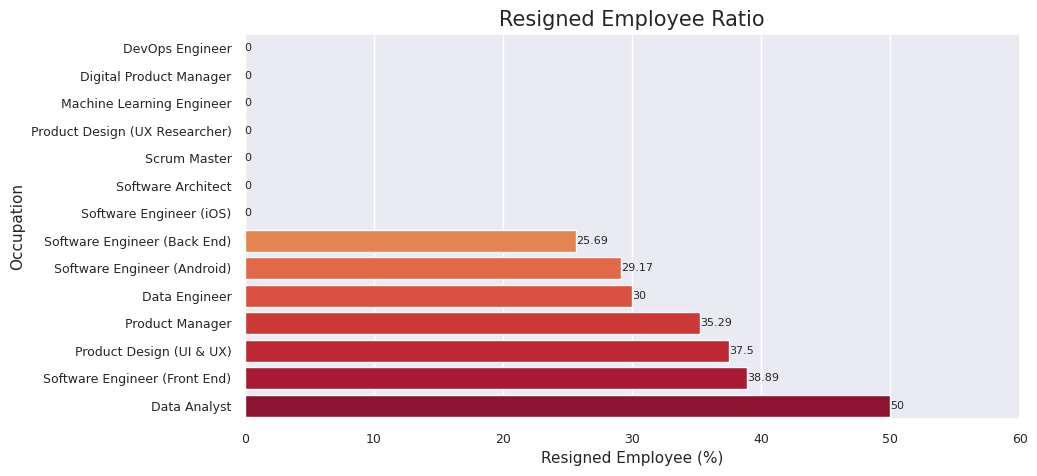

<Figure size 640x480 with 0 Axes>

In [141]:
# Visualize the resign reason

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.set_theme(style='darkgrid')
ax = sns.barplot(data = df_resign_work, x='Resign(%)', y='Pekerjaan', palette = 'YlOrRd',
            order = df_resign_work.sort_values('Resign(%)').Pekerjaan)
plt.title('Resigned Employee Ratio', size=15)
plt.xlabel('Resigned Employee (%)', fontsize=11)
plt.ylabel('Occupation', fontsize=11)
plt.xlim(0, 60)
plt.xticks(fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
ax.bar_label(ax.containers[0], fontsize=8)
plt.show()
plt.savefig('resigned_ration.png')

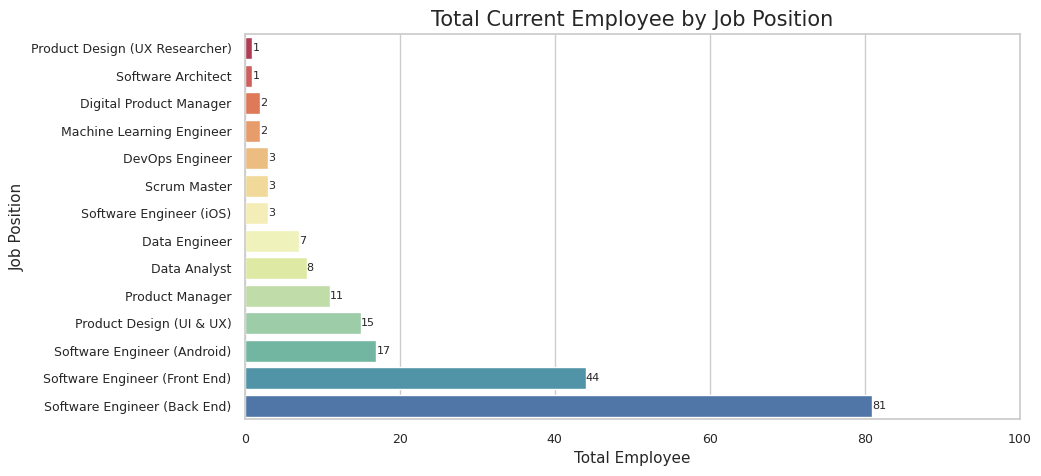

<Figure size 640x480 with 0 Axes>

In [140]:
# Visualize total current employee

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.set_theme(style='darkgrid')
ax = sns.barplot(data = df_resign_work, x='Total_Employee', y='Pekerjaan', palette = 'Spectral',
            order = df_resign_work.sort_values('Total_Employee').Pekerjaan)
plt.title('Total Current Employee by Job Position', size=15)
plt.xlabel('Total Employee', fontsize=11)
plt.ylabel('Job Position', fontsize=11)
plt.xlim(0, 100)
plt.xticks(fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
ax.bar_label(ax.containers[0], fontsize=8)
plt.show()
plt.savefig('current_employee.png')

Berdasarkan hasil analisis, pekerjaan Data Analyst merupakan pekerjaan yang paling banyak resign sehingga perlu dilakukan analisa lebih lanjut.

In [41]:
# Analyze Data Analyst Resign Reason

datanalyst = dfviz[(dfviz['Pekerjaan']=='Data Analyst') & dfviz['is_resign']==1 ].groupby(['Pekerjaan','JenjangKarir', 'PerformancePegawai','AlasanResign']).agg({'is_resign' : 'count'}).reset_index()
datanalyst

,Pekerjaan,JenjangKarir,PerformancePegawai,AlasanResign,is_resign
0,Data Analyst,Freshgraduate_program,Bagus,toxic_culture,1
1,Data Analyst,Freshgraduate_program,Biasa,internal_conflict,1
2,Data Analyst,Freshgraduate_program,Biasa,toxic_culture,1
3,Data Analyst,Freshgraduate_program,Sangat_bagus,internal_conflict,1
4,Data Analyst,Freshgraduate_program,Sangat_bagus,toxic_culture,3
5,Data Analyst,Freshgraduate_program,Sangat_kurang,toxic_culture,1


Terlihat bahwa Data Analyst yang resign semuanya berasal dari Fresh Graduate. Dilihat dari bagaimanapun kinerja pegawai, alasan resign mereka ada 2 yaitu toxic culture (budaya kerja toxic) dan konflik internal.

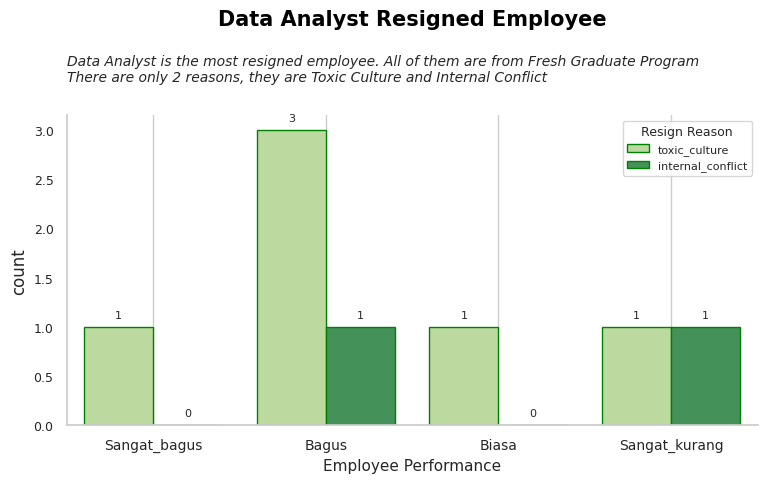

In [138]:
# Visualize Data Analyst Resigned Employee

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Data Analyst Resigned Employee", fontsize=15, color='black', weight='bold', pad=65)
plt.text(x=-0.5, y=3.5, s="Data Analyst is the most resigned employee. All of them are from Fresh Graduate Program \nThere are only 2 reasons, they are Toxic Culture and Internal Conflict", fontsize=10, fontstyle='italic')
sns.countplot(x='PerformancePegawai', data=dfclean[(dfclean['Pekerjaan']=='Data Analyst') & dfclean['is_resign']==1],
              hue='AlasanResign', edgecolor= 'green', palette='YlGn')

plt.tick_params(axis='both', which='major', labelsize=9)
plt.grid()
plt.legend(title='Resign Reason', title_fontsize=9, prop={'size':8})
plt.xlabel('Employee Performance', fontsize=11)
plt.xticks(range(0,4,1), labels=['Sangat_bagus', 'Bagus', 'Biasa', 'Sangat_kurang'], fontsize=10)

plt.bar_label(ax.containers[0], padding=5, fontsize=8)
plt.bar_label(ax.containers[1], padding=5, fontsize=8)

sns.despine()
plt.tight_layout()
plt.savefig('datanalyst_resigned.png')

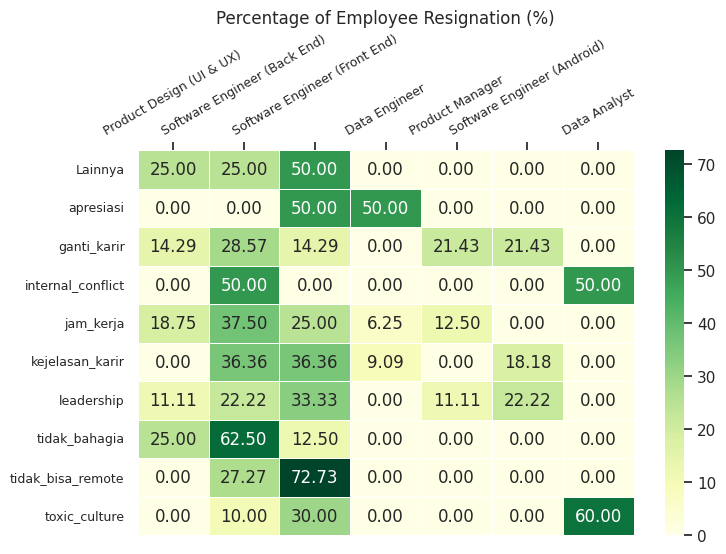

<Figure size 640x480 with 0 Axes>

In [139]:
df_resign_all = dfviz.query("is_resign == 1").groupby(["AlasanResign","Pekerjaan"])["EnterpriseID"].count().reset_index()

review_matrix = []
performance_sort = df_resign_all["Pekerjaan"].unique()
for x in df_resign_all["AlasanResign"].unique():
    temp_df = df_resign_all[df_resign_all["AlasanResign"]==x].set_index("Pekerjaan")["EnterpriseID"].reindex(performance_sort).fillna(0)
    temp_vector = [int(x) for x in temp_df.reset_index()["EnterpriseID"]]
    review_matrix.append(temp_vector)

#store as data frame
review_pivot = pd.DataFrame(review_matrix,columns=performance_sort,index=df_resign_all["AlasanResign"].unique())
division_list = np.sum(review_pivot,axis=1).reset_index()[0].tolist()
for index,value in enumerate(review_pivot.index):
    review_pivot.loc[value] = round(100.00*review_pivot.loc[value]/division_list[index],2)

# Create Plot
plt.figure(figsize=(8,5))
ax = sns.heatmap(review_pivot, linewidths=.5, annot=True, fmt=',.02f', cmap="YlGn", cbar=True)
ax.xaxis.set_ticks_position('top')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.rcParams.update({'font.size': 8})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 9)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title("Percentage of Employee Resignation (%)")
plt.show()
plt.savefig('all_resigned.png')

# Feature Engineering

In [62]:
dfpre = dfclean.copy()

## Feature Extraction

**Age**

In [63]:
# Extract birth year feature

dfpre['BirthYear'] = dfpre['TanggalLahir'].dt.year
dfpre['HiringYear'] = dfpre['TanggalHiring'].dt.year
dfpre['Age'] = dfpre['HiringYear'] - dfpre['BirthYear']

**Work Period**

In [64]:
dfpre['ResignYear'] = dfpre['TanggalResign'].map(lambda x: x[:4] if x != "-" else "-")
dfpre['WorkPeriod'] = dfpre['ResignYear'].map(lambda x: 0 if x == "-" else x).astype(int) - dfpre['HiringYear'].astype(int)
dfpre['WorkPeriod'] = dfpre['WorkPeriod'].map(lambda x: 0 if x < 0 else x)

In [65]:
dfpre['WorkPeriod'].describe()

count    287.000000
mean       1.254355
std        2.353715
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        9.000000
Name: WorkPeriod, dtype: float64

**Take part of Project**

In [66]:
dfpre['TakeProject'] = dfpre['JumlahKeikutsertaanProjek'].map(lambda x: 1 if x!=0 else 0)

**Time since last Employee Appraisal**

In [67]:
dfpre['EvalYear'] = dfpre['TanggalPenilaianKaryawan'].dt.year
dfpre['SinceLastEval'] = dfpre['EvalYear'] - dfpre['HiringYear']

In [68]:
dfpre[['Age', 'WorkPeriod', 'SinceLastEval']].describe()

,Age,WorkPeriod,SinceLastEval
count,287.000000,287.000000,287.000000
mean,34.080139,1.254355,5.933798
std,8.854922,2.353715,2.339791
min,19.000000,0.000000,1.000000
25%,28.000000,0.000000,4.000000
50%,32.000000,0.000000,6.000000
75%,39.000000,1.000000,7.000000
max,63.000000,9.000000,14.000000


In [69]:
dfpre = dfpre.drop(['Username' ,'JenisKelamin',  'AlasanResign','EvalYear', 'HiringYear', 'TanggalLahir','TanggalHiring',
                    'TanggalPenilaianKaryawan','TanggalResign', 'ResignYear', 'BirthYear'],axis=1)
dfpre.sample(3)

,EnterpriseID,StatusPernikahan,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,TingkatPendidikan,is_resign,Age,WorkPeriod,TakeProject,SinceLastEval
257,101135,Menikah,FullTime,Digital Product Manager,Freshgraduate_program,Sangat_kurang,Jakarta Timur,LinkedIn,4,4,0,0,15,Sarjana,0,37,0,0,4
52,100826,Lainnya,Outsource,Software Engineer (Back End),Freshgraduate_program,Biasa,Jakarta Utara,Indeed,3,5,0,0,7,Sarjana,0,21,0,0,7
104,105969,Belum_menikah,Outsource,Software Engineer (Front End),Senior_level,Sangat_bagus,Jakarta Barat,Indeed,4,3,0,0,14,Magister,1,22,4,0,7


## Preprocessing

In [70]:
dfpre2 = dfpre.copy()

In [71]:
dfpre2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   EnterpriseID                        287 non-null    int64 
 1   StatusPernikahan                    287 non-null    object
 2   StatusKepegawaian                   287 non-null    object
 3   Pekerjaan                           287 non-null    object
 4   JenjangKarir                        287 non-null    object
 5   PerformancePegawai                  287 non-null    object
 6   AsalDaerah                          287 non-null    object
 7   HiringPlatform                      287 non-null    object
 8   SkorSurveyEngagement                287 non-null    int64 
 9   SkorKepuasanPegawai                 287 non-null    int64 
 10  JumlahKeikutsertaanProjek           287 non-null    int64 
 11  JumlahKeterlambatanSebulanTerakhir  287 non-null    int64 

## Handle Outliers

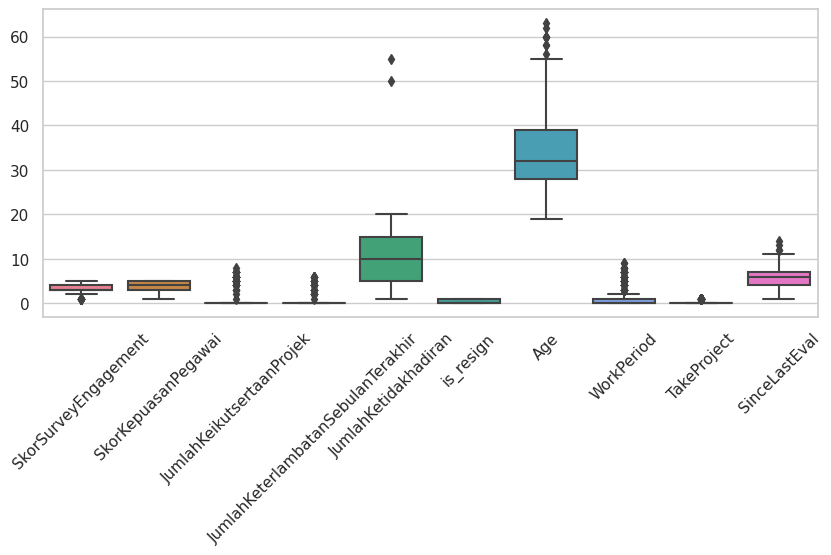

In [72]:
# Use Boxplot
df_numerical = dfpre2.select_dtypes(include = ["int64","float64"])

# Figure Size Setting
plt.figure(figsize=(10,4))

# Boxplot using Seaborn
sns.boxplot(data=df_numerical.drop(["EnterpriseID"],axis=1), palette='husl')
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [73]:
df_numerical.describe()

,EnterpriseID,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,is_resign,Age,WorkPeriod,TakeProject,SinceLastEval
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,105923.324042,3.101045,3.888502,1.167247,0.411150,10.439024,0.310105,34.080139,1.254355,0.219512,5.933798
std,4044.977599,0.836388,0.913060,2.285537,1.273018,6.829769,0.463344,8.854922,2.353715,0.414639,2.339791
min,100282.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.000000,0.000000,1.000000
25%,101269.000000,3.000000,3.000000,0.000000,0.000000,5.000000,0.000000,28.000000,0.000000,0.000000,4.000000
50%,106069.000000,3.000000,4.000000,0.000000,0.000000,10.000000,0.000000,32.000000,0.000000,0.000000,6.000000
75%,110514.500000,4.000000,5.000000,0.000000,0.000000,15.000000,1.000000,39.000000,1.000000,0.000000,7.000000
max,111703.000000,5.000000,5.000000,8.000000,6.000000,55.000000,1.000000,63.000000,9.000000,1.000000,14.000000


Untuk `SkorSurveyEngagement`,`JumlahKeikutsertaanProjek`, `JumlahKeterlambatanSebulanTerakhir`, `keikutsertaanproject_boolean`, ditoleransi untuk outliernya. Namun tidak untuk sisanya tidak karena standar deviasi yang tinggi.

In [74]:
# Function to check for outliers
def outlier_del(df, column, mode):
    q1 = df.iloc[:,column].quantile(0.25)
    q3 = df.iloc[:,column].quantile(0.75)
    iqr = q3-q1
    lower_tail = q1 - (1.5 * iqr)
    upper_tail = q3 + (1.5 * iqr)
    column_name = df.columns[column]
    total_outliers = df[(df.iloc[:,column] <= lower_tail)|(df.iloc[:,column] >= upper_tail)].iloc[:,column].count()
    total_row = df.iloc[:,column].count()
    percent_outliers = round(((total_outliers/total_row)*100),2)
    if mode == 'summary':
        return print('Total Outliers of ', column_name, ' :', total_outliers, ' and outliers percentage:', percent_outliers, '%')
    elif mode == 'df':
        return df[(df.iloc[:,column] >= lower_tail)&(df.iloc[:,column] <= upper_tail)]
    else :
        return print('Check the Input')

In [75]:
# Check the total outliers
column = [9, 12, 15, 18]

for i in range(0, len(column)):
    outlier_del(dfpre2, column[i], 'summary')

Total Outliers of  SkorKepuasanPegawai  : 0  and outliers percentage: 0.0 %
Total Outliers of  JumlahKetidakhadiran  : 2  and outliers percentage: 0.7 %
Total Outliers of  Age  : 9  and outliers percentage: 3.14 %
Total Outliers of  SinceLastEval  : 4  and outliers percentage: 1.39 %


In [76]:
dfpre2 = dfpre2[dfpre2.index.isin(outlier_del(dfpre, 12, 'df').reset_index()['index'])]
dfpre2 = dfpre2[dfpre2.index.isin(outlier_del(dfpre, 15, 'df').reset_index()['index'])]
dfpre2 = dfpre2[dfpre2.index.isin(outlier_del(dfpre, 18, 'df').reset_index()['index'])]
dfpre2.shape

(272, 19)

## Feature Encoding

**Division**

In [77]:
# Working Division
engineering_div = ['Software Engineer (Back End)',
               'Software Engineer (Front End)',
               'Software Engineer (Android)',
               'Software Engineer (iOS)',
               'DevOps Engineer',
               'Software Architect',
               'Machine Learning Engineer']
data_div = ['Data Analyst', 'Data Engineer']
product_div = ['Product Manager',
               'Product Design (UX Researcher)',
               'Product Design (UI & UX)',
               'Digital Product Manager',
               'Scrum Master']

dfpre2['Pekerjaan'] = dfpre2['Pekerjaan'].map(lambda x: 'engineering_div' if x in engineering_div else 'data_div' if x in data_div else 'product_div')

**Career Level**

In [78]:
# Career level encoding
career_lvl = {'Freshgraduate_program': 1,
              'Mid_level': 2,
              'Senior_level': 3}
dfpre2['JenjangKarir'] = dfpre2['JenjangKarir'].map(career_lvl)

**Employee Performance**

In [79]:
# Employee performance level
mapping_perform = {
    'Sangat_kurang' : 1,
    'Kurang' : 2,
    'Biasa' : 3,
    'Bagus' : 4,
    'Sangat_bagus' : 5}
dfpre2['PerformancePegawai'] = dfpre2['PerformancePegawai'].map(mapping_perform)

**Education Level**

In [80]:
mapping_edu = {
    'Sarjana' : 1,
    'Magister' : 2,
    'Doktor' : 3}
dfpre2['TingkatPendidikan'] = dfpre2['TingkatPendidikan'].map(mapping_edu)

In [81]:
dfpre2.rename(columns={'Pekerjaan': 'Job', 'StatusPernikahan': 'Status', 'PerformancePegawai': 'Performance', 'AsalDaerah': 'City',
                       'JenjangKarir' : 'Carrer_lvl', 'TingkatPendidikan' : 'Education', 'StatusKepegawaian' : 'Emp_Status'}, inplace=True)

In [82]:
dfpre2.sample(3)

,EnterpriseID,Status,Emp_Status,Job,Carrer_lvl,Performance,City,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,Education,is_resign,Age,WorkPeriod,TakeProject,SinceLastEval
254,111176,Bercerai,Outsource,product_div,2,1,Jakarta Selatan,Google_Search,3,5,4,0,14,2,1,26,5,1,7
50,100381,Menikah,FullTime,product_div,1,1,Jakarta Pusat,Indeed,3,3,0,0,2,1,1,55,0,0,7
248,100353,Belum_menikah,FullTime,product_div,1,4,Jakarta Utara,Google_Search,4,4,0,0,20,1,1,30,7,0,7


**Frequency Encoding**

In [83]:
# Frequency Encoding
freq_code = dfpre2.groupby('HiringPlatform').size()/len(dfpre2)
dfpre2['Hiring_Platform'] = dfpre2["HiringPlatform"].map(freq_code)
dfpre2.drop(["HiringPlatform"],axis=1,inplace=True)

**One-Hot Encoding**

In [84]:
# One Hot Encoding

dfpre2 = pd.get_dummies(dfpre2, columns=['Job', 'Status', 'City', 'Emp_Status'])
dfpre2.sample(3)

,EnterpriseID,Carrer_lvl,Performance,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,Education,is_resign,Age,WorkPeriod,TakeProject,SinceLastEval,Hiring_Platform,Job_data_div,Job_engineering_div,Job_product_div,Status_Belum_menikah,Status_Bercerai,Status_Lainnya,Status_Menikah,City_Jakarta Barat,City_Jakarta Pusat,City_Jakarta Selatan,City_Jakarta Timur,City_Jakarta Utara,Emp_Status_FullTime,Emp_Status_Internship,Emp_Status_Outsource
220,101434,1,5,4,4,0,0,11,2,0,29,0,0,5,0.242647,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1
171,111220,1,5,2,2,0,6,6,1,1,26,7,0,3,0.242647,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
10,105548,2,2,3,2,0,3,3,1,1,35,9,0,10,0.073529,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0


In [85]:
dfpre2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 286
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   EnterpriseID                        272 non-null    int64  
 1   Carrer_lvl                          272 non-null    int64  
 2   Performance                         272 non-null    int64  
 3   SkorSurveyEngagement                272 non-null    int64  
 4   SkorKepuasanPegawai                 272 non-null    int64  
 5   JumlahKeikutsertaanProjek           272 non-null    int64  
 6   JumlahKeterlambatanSebulanTerakhir  272 non-null    int64  
 7   JumlahKetidakhadiran                272 non-null    int64  
 8   Education                           272 non-null    int64  
 9   is_resign                           272 non-null    int64  
 10  Age                                 272 non-null    int64  
 11  WorkPeriod                          272 non-n

## Handle Imbalance

In [86]:
dfnew = dfpre2.copy().set_index(['EnterpriseID'])
dfnew.sample(3)

,Carrer_lvl,Performance,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,Education,is_resign,Age,WorkPeriod,TakeProject,SinceLastEval,Hiring_Platform,Job_data_div,Job_engineering_div,Job_product_div,Status_Belum_menikah,Status_Bercerai,Status_Lainnya,Status_Menikah,City_Jakarta Barat,City_Jakarta Pusat,City_Jakarta Selatan,City_Jakarta Timur,City_Jakarta Utara,Emp_Status_FullTime,Emp_Status_Internship,Emp_Status_Outsource
EnterpriseID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100639,2,1,1,1,0,2,17,1,0,25,0,0,8,0.040441,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
105548,2,2,3,2,0,3,3,1,1,35,9,0,10,0.073529,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
110842,3,5,4,4,5,0,11,2,0,34,0,1,5,0.088235,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1


In [87]:
# Check feature target

dfnew['is_resign'].value_counts()

0    188
1     84
Name: is_resign, dtype: int64

In [88]:
from sklearn.model_selection import train_test_split

# Split the data
features = dfnew.select_dtypes(["int64", "float64", "uint8"]).columns
x = dfnew[features].drop('is_resign', axis=1)
y = dfnew['is_resign'].tolist()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [89]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from IPython.display import clear_output

tl = TomekLinks(sampling_strategy="auto")
rus = RandomUnderSampler(random_state=123)
enn = EditedNearestNeighbours()
senn = SMOTEENN(random_state=123)
stl = SMOTETomek(random_state=123)

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix, classification_report

In [92]:
# Thresholding Imbalanced Learning using ML Metrics

list_all_imbalanced = [tl,rus,enn,senn,stl]

imbalance_strategy = []
score_accuracy = []
score_precision = []
score_recall = []
score_auc = []
time_training = []

for imbalanced_learning in list_all_imbalanced:
    print(f"Processing {imbalanced_learning.__class__.__name__}")
    start_time = time.time()
    model = XGBClassifier(verbosity = 0,use_label_encoder = False, random_state = 123)
    #Define pipeline
    pipeline=Pipeline(steps=[("r", imbalanced_learning), ("m", model)])

    #Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Evaluate model
    scoring=["accuracy","precision_macro","recall_macro","roc_auc"]
    scores = cross_validate(pipeline, xtrain, ytrain, scoring=scoring, cv=cv, n_jobs=-1)

    imbalance_strategy.append(imbalanced_learning.__class__.__name__)
    score_accuracy.append(np.mean(scores["test_accuracy"]))
    score_precision.append(np.mean(scores["test_precision_macro"]))
    score_recall.append(np.mean(scores["test_recall_macro"]))
    score_auc.append(np.mean(scores["test_roc_auc"]))
    end_time = time.time()
    time_training.append(time.strftime('%H:%M:%S', time.gmtime(end_time - start_time)))

# Result
clear_output()
df_evaluation = pd.DataFrame({"Imbalance_Strategy":imbalance_strategy,
                              "Accuracy": score_accuracy,
                              "Precision": score_precision,
                              "Recall": score_recall,
                              "AUC": score_auc,
                              "Training_Time": time_training})
df_evaluation.sort_values(["AUC"],ascending=False)

,Imbalance_Strategy,Accuracy,Precision,Recall,AUC,Training_Time
3,SMOTEENN,0.943074,0.953645,0.918492,0.923122,00:00:01
0,TomekLinks,0.950938,0.961859,0.927381,0.914233,00:00:06
2,EditedNearestNeighbours,0.924747,0.924055,0.908492,0.910847,00:00:05
1,RandomUnderSampler,0.921717,0.920530,0.906270,0.907725,00:00:02
4,SMOTETomek,0.940260,0.949042,0.919603,0.907143,00:00:01


TomekLinks menunjukkan yang paling baik diantara lainnya

# Modeling

In [93]:
#Initialize the classifier model
model1 = GaussianNB()
model2 = SVC(random_state=0)
model3 = RandomForestClassifier(random_state=0)
model4 = LogisticRegression()
model5 = DecisionTreeClassifier(random_state=0)
model6 = BaggingClassifier(random_state=0,base_estimator=model5)
model7 = GradientBoostingClassifier(random_state=0)
model8 = AdaBoostClassifier(random_state=0,base_estimator=model5)
model9 = KNeighborsClassifier()
model10 = MLPClassifier()
model11 = XGBClassifier(random_state=0)
model12 = LGBMClassifier(random_state=0)
model13 = CatBoostClassifier(random_state=0)

classifier_list = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12, model13]

In [94]:
ml_model = []
score_accuracy = []
score_precision = []
score_recall = []
score_auc = []
time_training = []

for model in classifier_list:
    print(f"Processing {model.__class__.__name__}")

    start_time = time.time()
    tl = TomekLinks(sampling_strategy="auto")

    #Define pipeline
    pipeline=Pipeline(steps=[("r", tl), ("m", model)])

    #Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Evaluate model
    scoring=["accuracy","precision_macro","recall_macro","roc_auc"]

    scores = cross_validate(pipeline,
                            xtrain,
                            ytrain,
                            scoring = scoring,
                            cv = cv,
                            n_jobs = -1)

    ml_model.append(model.__class__.__name__)
    score_accuracy.append(np.mean(scores["test_accuracy"]))
    score_precision.append(np.mean(scores["test_precision_macro"]))
    score_recall.append(np.mean(scores["test_recall_macro"]))
    score_auc.append(np.mean(scores["test_roc_auc"]))
    end_time = time.time()
    time_training.append(time.strftime('%H:%M:%S', time.gmtime(end_time - start_time)))

# Result
clear_output()
df_model = pd.DataFrame({"ML_Model":ml_model,
                         "Accuracy": score_accuracy,
                         "Precision": score_precision,
                         "Recall": score_recall,
                         "AUC": score_auc,
                         "Training_Time": time_training})
df_model.sort_values(["AUC"],ascending=False)

,ML_Model,Accuracy,Precision,Recall,AUC,Training_Time
1,SVC,0.870924,0.923931,0.790079,0.939153,00:00:00
0,GaussianNB,0.953968,0.965560,0.929603,0.931772,00:00:04
5,BaggingClassifier,0.954040,0.965140,0.929603,0.925079,00:00:01
2,RandomForestClassifier,0.955483,0.971430,0.927778,0.916455,00:00:04
10,XGBClassifier,0.950938,0.961859,0.927381,0.914233,00:00:01
11,LGBMClassifier,0.949278,0.959065,0.926270,0.908571,00:00:03
6,GradientBoostingClassifier,0.952381,0.963996,0.928492,0.906614,00:00:02
4,DecisionTreeClassifier,0.910823,0.903853,0.900159,0.900159,00:00:00
12,CatBoostClassifier,0.958586,0.973391,0.932937,0.899048,00:00:43
7,AdaBoostClassifier,0.908081,0.903787,0.897937,0.897937,00:00:01


### Tuning Hyperparameter

**CatBoostClassifier**

In [109]:
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample

from timeit import default_timer as timer
from sklearn.model_selection import cross_val_score

# TomekLinks Application
tl = TomekLinks(sampling_strategy="auto")

x_tl, y_tl = tl.fit_resample(xtrain, ytrain)

# Hyperparameter Space
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.quniform('n_estimators',100,500,20),
    "max_depth" : hp.quniform('max_depth', 3, 10, 1)
}

def rskf_metrics(model, X, y, scoring_used = "precision", cv_method = "", nfolds = 10):
    if cv_method == "":
        cv_method = RepeatedStratifiedKFold(n_splits=nfolds, n_repeats=3, random_state=1)

    metrics_calculation= cross_val_score(model, X, y, scoring=scoring_used, cv = cv_method)

    return(metrics_calculation)

def objective(params,
              n_folds=10,
              X=x_tl,
              y=y_tl,
              scoring_used="precision",
              cv_used=""):

    global ITERATION
    ITERATION += 1

    # Perform n_folds cross validation
    start = timer()
    model_hyper = CatBoostClassifier(random_state = 123,verbose=0, **params)
    run_time = timer() - start

    metrics_used = np.mean(rskf_metrics(model_hyper, X, y))

    # Dictionary with information for evaluation
    return {'loss': metrics_used, 'params': params, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [110]:
%%time
from hyperopt import fmin

# Global variable
global  ITERATION

ITERATION = 0

# optimization algorithm
tpe_algorithm = tpe.suggest

# Hyperopts Trials() records all the model and run artifacts.
trials = Trials()

# Fmin will call the objective funbction with selective param set.
# The choice of algorithm will narrow the searchspace.

best_classifier = fmin(objective, space, algo=tpe_algorithm,
                       max_evals=100, trials=trials)

100%|██████████| 100/100 [21:27<00:00, 12.88s/trial, best loss: 0.9620634920634922]
CPU times: user 27min 44s, sys: 4min 12s, total: 31min 57s
Wall time: 21min 27s


In [111]:
from hyperopt import space_eval

# Best_params of the best model
best_params = space_eval(space, best_classifier)
best_params

{'learning_rate': 0.19414771738366432, 'max_depth': 3.0, 'n_estimators': 320.0}

In [113]:
catboost_model = CatBoostClassifier(random_state = 123, **best_classifier)
catboost_model.fit(x_tl,y_tl,verbose=0)

y_pred = catboost_model.predict(xtest)
y_pred_proba = catboost_model.predict_proba(xtest)

In [114]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def roc_plot(clf, X_test,y_test):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

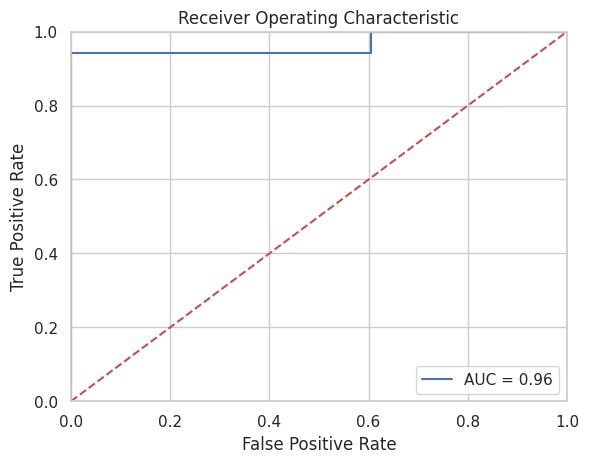

In [115]:
roc_plot(catboost_model,xtest,ytest)

**GaussianNB**

In [102]:
from sklearn.model_selection import GridSearchCV

# TomekLinks Application
tl = TomekLinks(sampling_strategy="auto")

x_tl, y_tl = tl.fit_resample(xtrain, ytrain)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=model1,
                 param_grid=params_NB,
                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1),   # use any cross validation technique
                 verbose=1,
                 scoring='precision')
gs_NB.fit(x_tl, y_tl)

gs_NB.best_params_

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


{'var_smoothing': 0.23101297000831597}

In [106]:
gnb_model = GaussianNB(var_smoothing = 0.231)
gnb_model.fit(x_tl,y_tl)

y_pred = gnb_model.predict(xtest)
y_pred_proba = gnb_model.predict_proba(xtest)

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def roc_plot(clf, X_test,y_test):
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

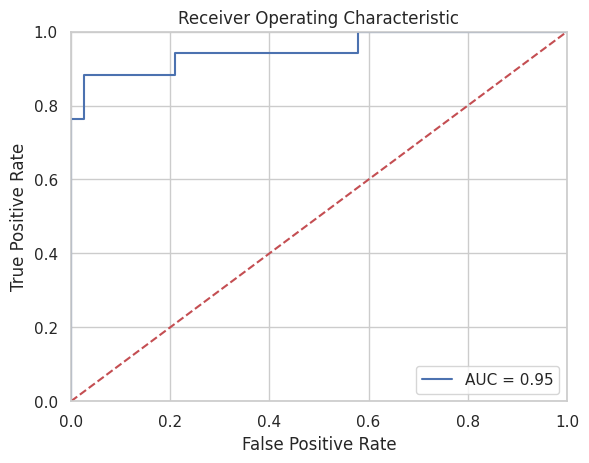

In [108]:
roc_plot(gnb_model,xtest,ytest)

**RandomForestClassifier**

In [116]:
# Fit the grid search to the data
from sklearn.model_selection import RandomizedSearchCV

# TomekLinks Application
tl = TomekLinks(sampling_strategy="auto")

x_tl, y_tl = tl.fit_resample(xtrain, ytrain)

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rf_model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)
# fit
rf_model.fit(x_tl, y_tl)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [117]:
print(rf_model.best_params_)

{'n_estimators': 40, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': None}


In [132]:
rfc_model = RandomForestClassifier(n_jobs = -1, random_state=42)
rfc_model.fit(x_tl,y_tl)

y_pred = rfc_model.predict(xtest)
y_pred_proba = rfc_model.predict_proba(xtest)

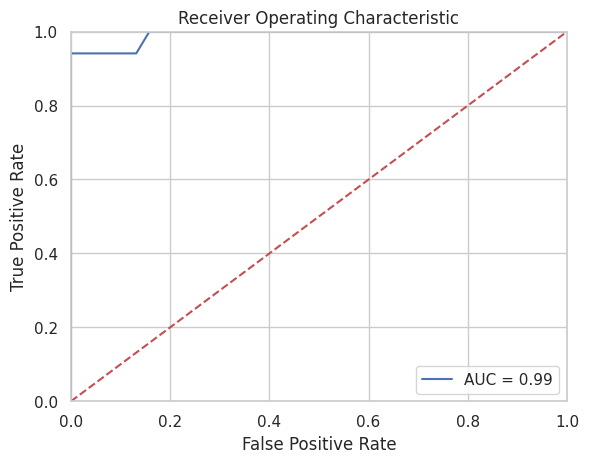

In [133]:
roc_plot(rfc_model,xtest,ytest)

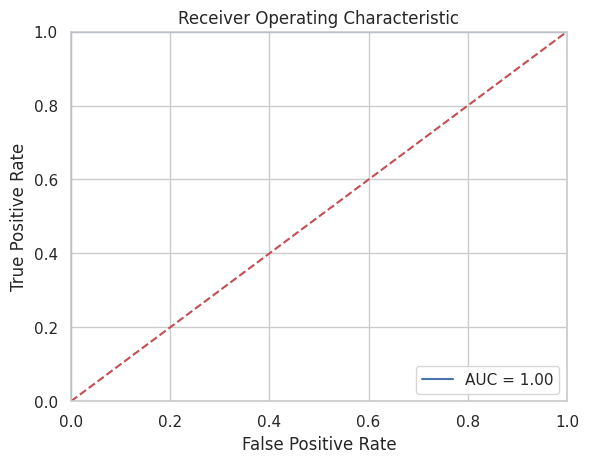

In [134]:
roc_plot(rfc_model,xtrain,ytrain)

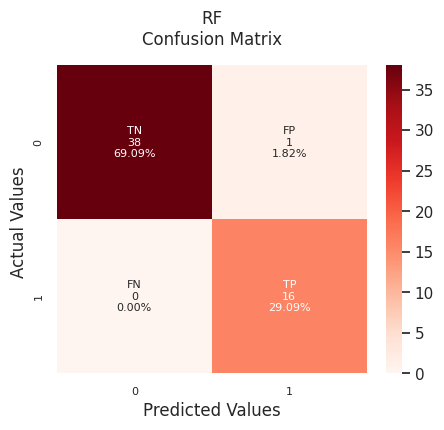

In [135]:
# Confusion Matrix Random Forest

predictions_XGB = rfc_model.predict(xtest)
cf_matrix = confusion_matrix(predictions_XGB, ytest)

group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(5, 4))
plt.tick_params(axis='both', which='major', labelsize=8)
plt.rcParams.update({'font.size': 8})
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

plt.title('RF\nConfusion Matrix', pad=15)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values ');
plt.savefig('RFC ConfMtrx', dpi = 200)

Dari hasil percobaan tuning hyperparameter terhadap 3 model skor metriks yang tinggi, terlihat bahwa model RandomForest memiliki performa yang terbaik. Hasil train dan test yang bernilai 1.00 dan 0.99 mungkin saja terjadi karena data yang dimiliki hanya sedikit, yaitu sampel 20% dari 272. Adapun jika data yang dimiliki lebih banyak, kemungkinan skor juga bisa saja berkurang.

Text(0.5, 1.0, 'Feature Importance Score')

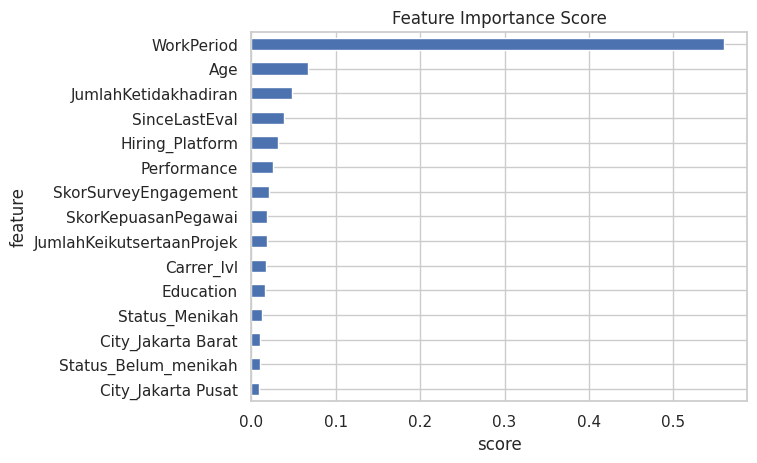

In [128]:
# Displays a feature importance graph

# Training model xgboost
modelrf = RandomForestClassifier()
modelrf.fit(xtrain, ytrain)

feat_importances = pd.Series(modelrf.feature_importances_, index=x.columns)
ax = feat_importances.nlargest(15).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('Feature Importance Score')

<Axes: xlabel='SinceLastEval', ylabel='Partial dependence'>

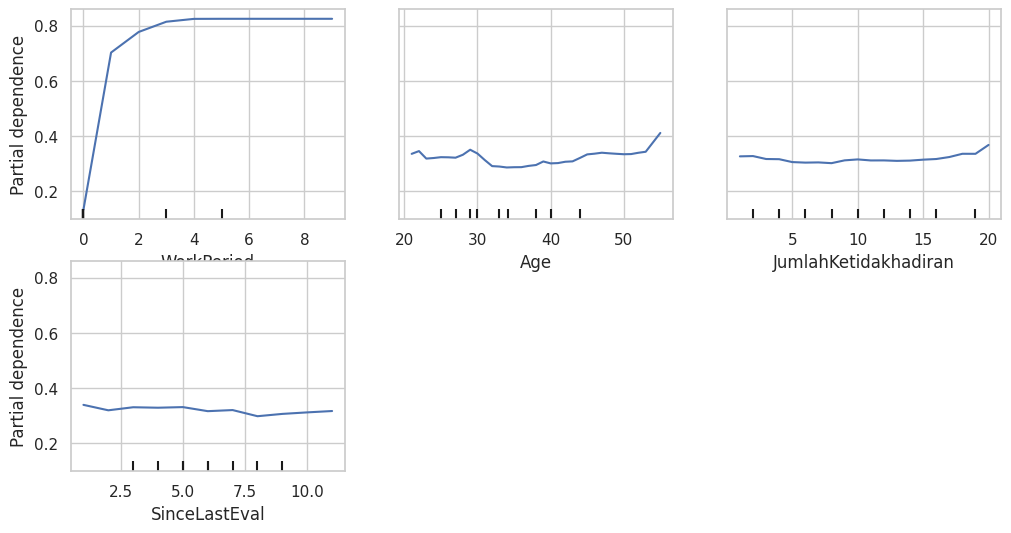

In [137]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(100,200)

tree_disp = PartialDependenceDisplay.from_estimator(rfc_model, x_tl, ["WorkPeriod", "Age", "JumlahKetidakhadiran", "SinceLastEval"], ax=ax)
tree_disp.axes_[0][0]
tree_disp.axes_[0][1]
tree_disp.axes_[1][1]
tree_disp.axes_[1][0]

Dari grafik feature importance diatas, lama tahun kerja pegawai menunjukkan kepentingan yang sangat tinggi. Hal ini menunjukkan bahwa semakin lama seseorang sudah bekerja di perusahaan (dalam hitungan tahun) maka resiko untuk resign juga semakin tinggi. Faktor selanjutnya yaitu jarak waktu terakhir penilaian terhadap karyawan. Semakin jauh jarak nya, semakin cenderung pegawai tersebut memutuskan untuk resign. Faktor umur juga berpengaruh terhadap kecenderungan pegawai dalam resign.

Hal tersebut menunjukkan bahwa kondisi kesehatan pegawai perusahaan sedang tidak baik-baik saja. Bukannya semakin betah di perusahaan, namun pegawai memilih untuk resign.

Recommendation :

1. Melakukan evaluasi rutinan terhadap kepuasan pegawai ditinjau dari budaya perusahaan dan hubungan dengan rekan kerja.  Hal ini terlihat dari alasan terbesar banyak pegawai yang resign, yaitu toxic culture dan conflict internal.  

2. Perusahaan menyediakan fasilitas terapi mental (mendatangkan psikolog atau psikiater) sebagai wadah pegawai dalam mengeluarkan isi hatinya.  

3. Menumbuhkan budaya saling mengapresiasi sesama rekan kerja agar pegawai tidak merasa hanya bekerja dalam tekanan.
